In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from v1dd_public import ARTIFACT_DIR
import seaborn as sns

In [2]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mouse_colors_2 = {409828: "#66CCEE", 416296: "#228833", 427836: '#CCBB44', 438833: '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = [409828, 416296, 427836, 438833]
mouse_mapping = {
    '409828': 'Mouse 1',
    '416296': 'Mouse 2',
    '427836': 'Mouse 3',
    '438833': 'Mouse 4'
}

stim_types = [
    "drifting_gratings_full", 
    "drifting_gratings_windowed", 
    "natural_images",
    "natural_images_12", 
    ]
decode_dims = {
    "drifting_gratings_full": "direction",
    "drifting_gratings_windowed": "direction",
    "natural_images": "image_index",
    "natural_images_12": "image_index",
               }

multi_stim_pairs = {
        "drifting_gratings_full": "drifting_gratings_windowed",
        "drifting_gratings_windowed": "drifting_gratings_full",
        "natural_images": "natural_images_12",
        "natural_images_12": "natural_images",
    }

chance = {
    "drifting_gratings_full": 1/12, 
    "drifting_gratings_windowed": 1/12, 
    "natural_images": 1/118,
    "natural_images_12": 1/12,
    }

In [3]:
def depth_vol_mapping(vol_id, plane_id):
    plane_list = [int(p) for p in list(str(plane_id))]
    plane_index = int(np.mean(plane_list) - 1) # plane index is 0-based, so subtract 1
    depth_values = {
                1: [50, 66, 82, 98, 114, 130],
                2: [146, 162, 178, 194, 210, 226],
                3: [242, 258, 274, 290, 306, 322],
                4: [338, 354, 370, 386, 402, 418],
                5: [434, 450, 466, 482, 498, 514],
                6: [500],
                7: [525],
                8: [550],
                9: [575],
                'a': [600],
                'b': [625],
                'c': [650],
                'd': [675],
                'e': [700],
                'f': [725]
            }
    return depth_values[vol_id][plane_index]

### FIGURE 2D -- DECODING DEPTH TRENDS

In [5]:
tag = "2025-08-08_3"
bootstrap_size = 1
repetitions = 1
num_planes = 1
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}'
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])
    
    results_df['stim_type_training'] = stim_type
    results_df['stim_type_testing'] = other_stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)

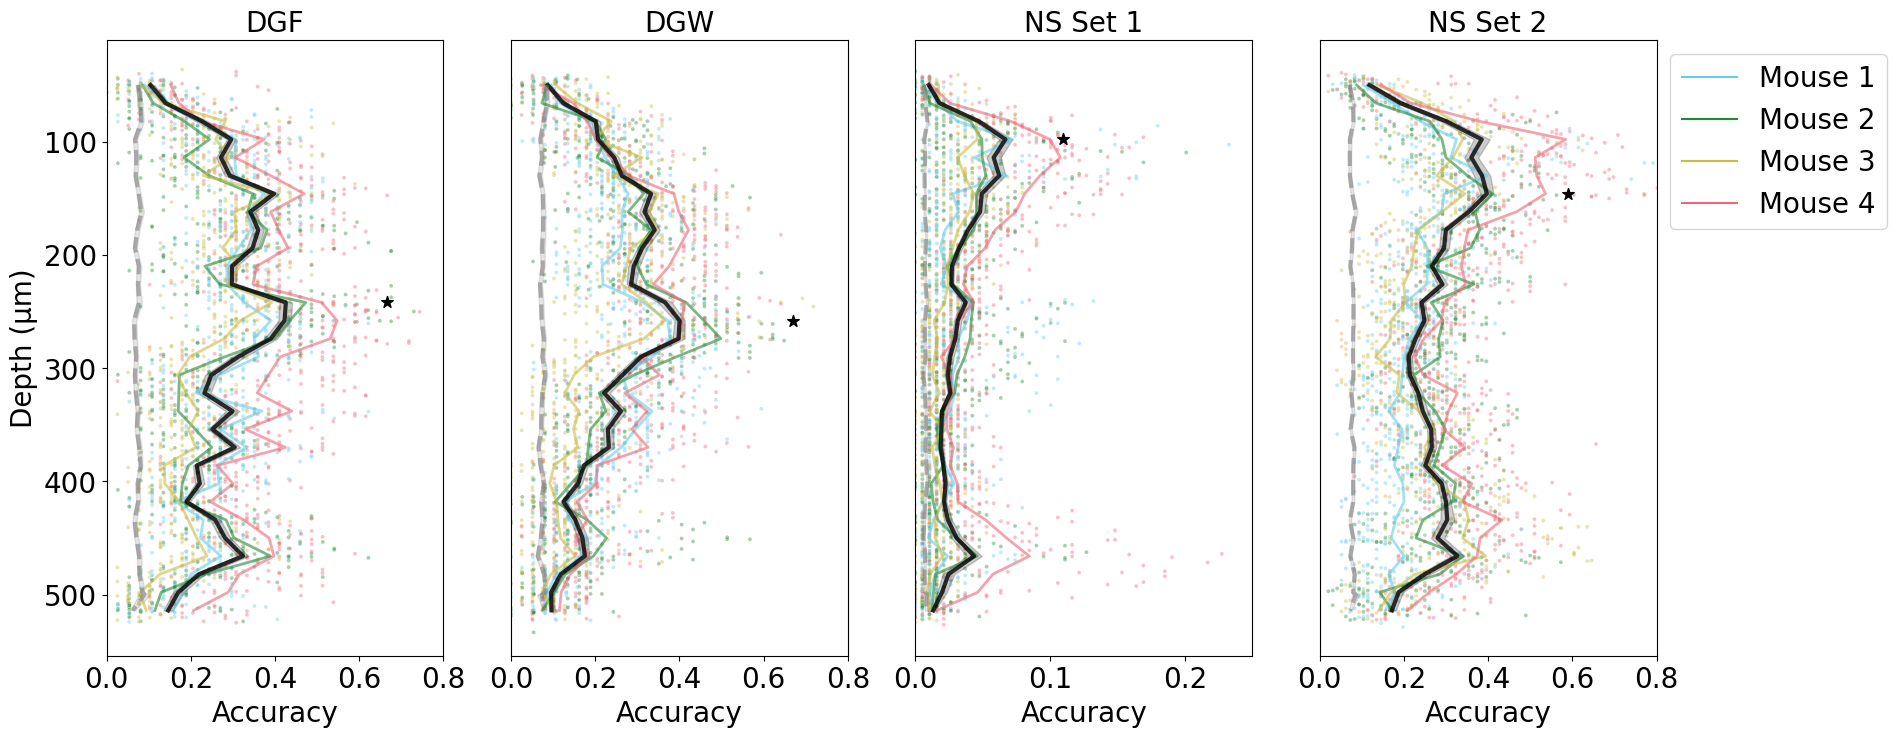

In [11]:
#### Plotting decoding accuracies for each mouse

# Some parameters for the plot
z_values = all_results_df['depth'].unique()
z_values = [z_val for z_val in z_values if z_val < 515]  # Filter out depths greater than 514
z_values = np.array(z_values)
z_values = np.sort(z_values)
# titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2']
titles = {
    'drifting_gratings_full': 'DGF',
    'drifting_gratings_windowed': 'DGW',
    'natural_images': 'NS Set 1',
    'natural_images_12': 'NS Set 2'
}
n_stims = 4
jitter_amount = 5

fig, axs = plt.subplots(1, n_stims, figsize=(20, 8))
fontsize = 20

# Iterate through each stimulus type and plot the results for all the mice
for stim_idx, stim_type in enumerate(stim_types):
    ax = axs[stim_idx]

    temp_df = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514) & (all_results_df['depth'] != 500)]
    temp_df = temp_df.explode('val_accuracy')
    # temp_df['val_accuracy'] = temp_df['val_accuracy'] / chance[stim_type]

    sns.lineplot(
        data=temp_df,
        x='val_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False if stim_idx != 3 else True,
    )

    ax.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
        loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize, title_fontsize=fontsize) if stim_idx == 3 else None

    sns.lineplot(data=temp_df, 
        x='val_accuracy', 
        y='depth', 
        color='black', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linewidth=3, 
        alpha=0.8, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    # Put asterisk next to the depth where the max mean
    sub_df = temp_df.groupby('depth')['val_accuracy'].mean().reset_index()
    sub_array = sub_df['val_accuracy'].values
    axs[stim_idx].scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
        color='black', marker='*', s=75, edgecolor='black', zorder=1)
    
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
        x='val_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        s=8,
        alpha=0.4,
        ax=ax,
        legend=False,
        zorder=0,
    )

    # Add shuffled data line
    temp_df_shuf = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514)]
    temp_df_shuf = temp_df_shuf.explode('shuf_val_accuracy')
    # temp_df_shuf['shuf_val_accuracy'] = temp_df_shuf['shuf_val_accuracy'] / chance[stim_type]
    
    sns.lineplot(data=temp_df_shuf, 
        x='shuf_val_accuracy', 
        y='depth', 
        color='grey', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linestyle='--',
        linewidth=3, 
        alpha=0.6, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    ax.set_title(titles[stim_type], fontsize=fontsize)
    ax.set_xlabel('Accuracy', fontsize=fontsize)
    ax.set_ylabel("Depth (µm)", fontsize=fontsize) if stim_idx == 0 else ax.set_ylabel(" ")
    ax.set_yticks([]) if stim_idx != 0 else None
    ax.set_ylim(z_values.min() - 40, z_values.max() + 40)
    ax.set_xlim(left=0, right=0.8) if stim_idx != 2 else ax.set_xlim(left=0, right=0.25)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)
    ax.invert_yaxis()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG2D_nobootstrapping_1plane_valaccuracies_decoding.svg'), dpi=300)

In [7]:
# -----------------------------
# Helper to convert p → stars
# -----------------------------
def p_to_stars(p):
    alpha_levels = [0.05, 0.01, 0.001, 0.0001]  # thresholds for *, **, ***, ****
    if np.isnan(p):
        return ""
    if p < alpha_levels[3]:
        return "****"
    elif p < alpha_levels[2]:
        return "***"
    elif p < alpha_levels[1]:
        return "**"
    elif p < alpha_levels[0]:
        return "*"
    return ""

/home/naomi/anaconda3/envs/v1dd-public-1/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Best depth = 242, mean accuracy = 0.426


/home/naomi/anaconda3/envs/v1dd-public-1/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Best depth = 258, mean accuracy = 0.401


/home/naomi/anaconda3/envs/v1dd-public-1/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Best depth = 98, mean accuracy = 0.067


/home/naomi/anaconda3/envs/v1dd-public-1/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Best depth = 146, mean accuracy = 0.397


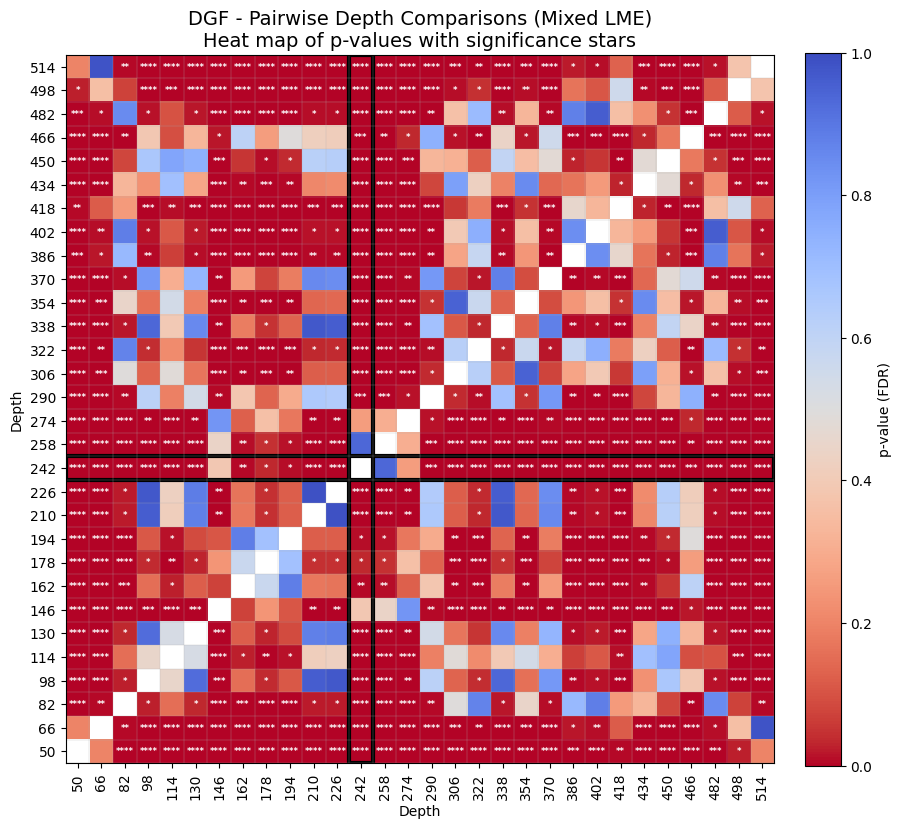

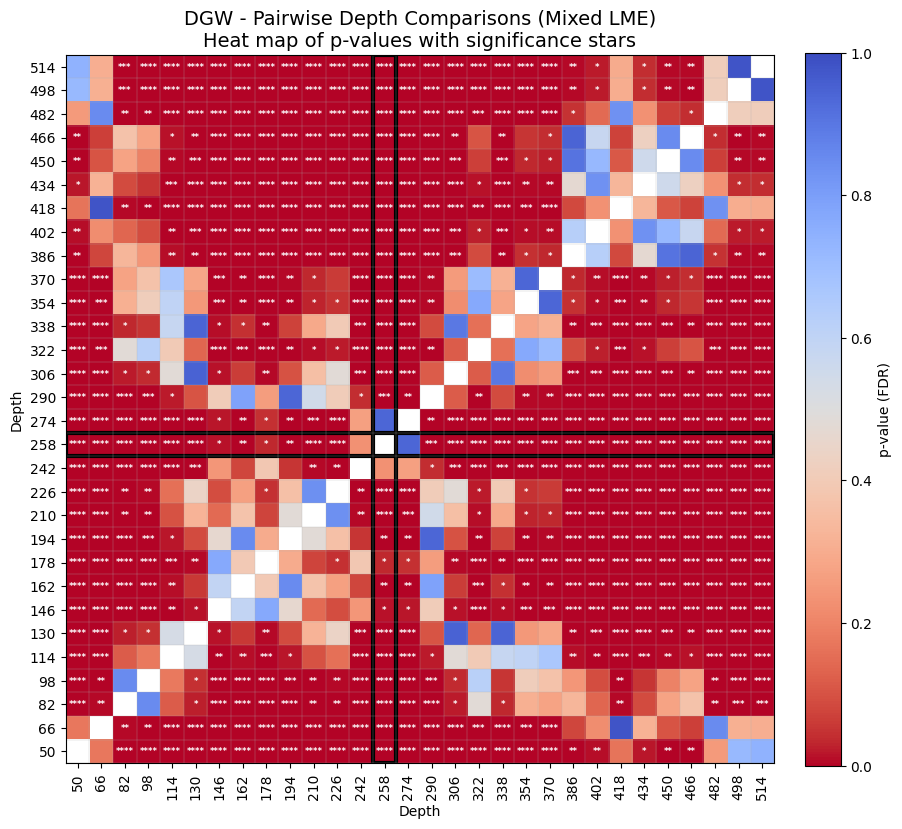

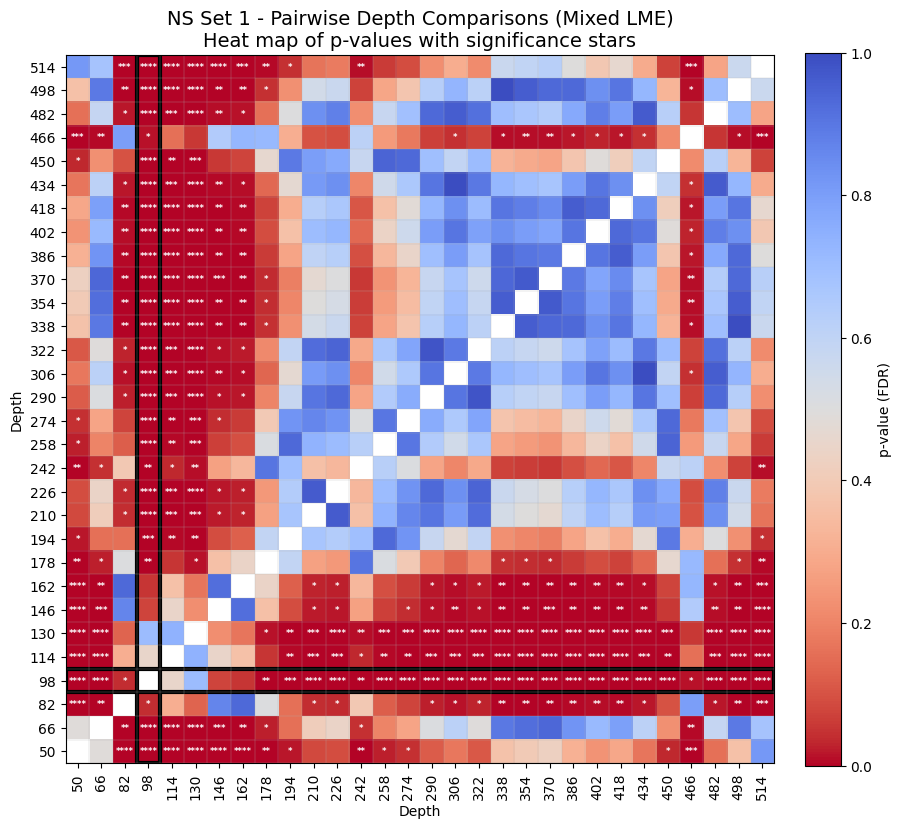

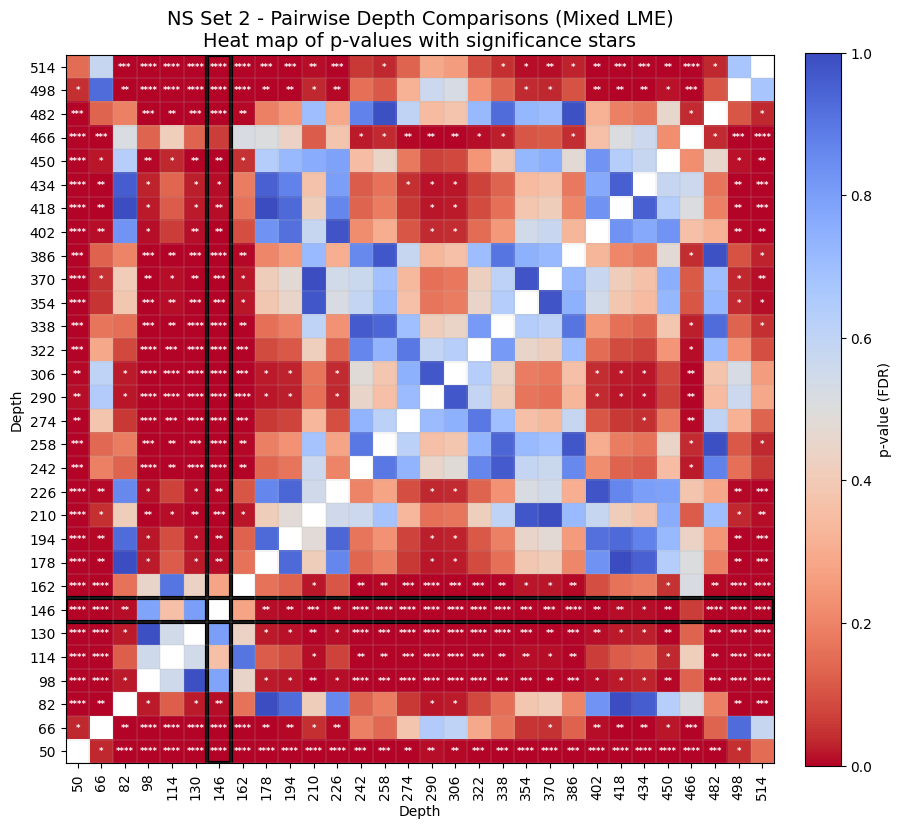

In [8]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests


# titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2']
titles = {
    'drifting_gratings_full': 'DGF',
    'drifting_gratings_windowed': 'DGW',
    'natural_images': 'NS Set 1',
    'natural_images_12': 'NS Set 2'
}


# fig, axs = plt.subplots(1, len(stim_types), figsize=(25, 5))
for idx, stim_type in enumerate(stim_types):
    sub_df = all_results_df[(all_results_df['depth'] <= 514) & (all_results_df['depth'] != 500)]
    mean_acc_df = sub_df.explode('val_accuracy').groupby(by=['mouse_id', 'column_id', 'volume_id', 'depth', 'stim_type_training'])['val_accuracy'].mean()
    mean_acc_df = mean_acc_df.reset_index()
    mean_acc_DGF_df = mean_acc_df[mean_acc_df['stim_type_training'] == stim_type].drop(columns=['stim_type_training'])

    df = mean_acc_DGF_df.copy()
    df = df.sort_values(by='depth').reset_index()
    df['mouse_id'] = df['mouse_id'].astype("category")
    df['column_id'] = df['column_id'].astype("category")
    df['depth'] = df['depth'].astype("category")
    depth_levels = df.depth.unique()

    # 2) Fit the mixed model: accuracy ~ depth + (1|mouse) + (1|mouse:column)
    res = smf.mixedlm(
        "val_accuracy ~ C(depth)",
        data=df,
        groups=df["mouse_id"],
        re_formula="~1",
        vc_formula={"column_id": "0 + C(column_id)"}
    ).fit(method="lbfgs")

    # 3) Build “EMM” vectors (fixed-effects means per depth)
    fe_names = res.fe_params.index.tolist()
    beta = res.fe_params.values
    Sigma = res.cov_params().loc[fe_names, fe_names].values  # cov of fixed effects
    baseline = depth_levels[0]

    def v_for(level):
        v = np.zeros(len(fe_names))
        v[fe_names.index("Intercept")] = 1.0
        name = f"C(depth)[T.{level}]"
        if name in fe_names: v[fe_names.index(name)] = 1.0
        return v

    R = np.vstack([v_for(d) for d in depth_levels])  # rows are depths

    # 4) Pairwise contrasts for all depth pairs
    rows = []
    for i, j in itertools.combinations(range(len(depth_levels)), 2):
        L = R[i] - R[j]
        diff = float(L @ beta)
        se   = float(np.sqrt(L @ Sigma @ L))
        z    = diff / se if se > 0 else np.inf
        p    = 2 * (1 - norm.cdf(abs(z)))
        rows.append({
            "depth_a": depth_levels[i],
            "depth_b": depth_levels[j],
            "diff": diff,
            "se": se,
            "z": z,
            "p_raw": p
        })
    contrasts = pd.DataFrame(rows)

    # 5) Add FDR (BH)
    contrasts["p_fdr_bh"]    = multipletests(contrasts["p_raw"], method="fdr_bh")[1]

    # Done: 'contrasts' now has raw and FDR p-values for every pair
    contrasts.sort_values("p_fdr_bh", inplace=True)


    ########### Plotting ###########
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    show_upper_triangle_only = False             # set False to show entire matrix
    mark_diagonal = False                       # usually we leave diagonal unmarked

    ## Build the matrix of p-values
    depth_to_idx = {d:i for i,d in enumerate(depth_levels)}
    K = len(depth_levels)

    P = np.ones((K, K), dtype=float)  # initialize to 1s (diagonal = 1)
    for _, row in contrasts.iterrows():
        i = depth_to_idx[row["depth_a"]]
        j = depth_to_idx[row["depth_b"]]
        p = float(row["p_fdr_bh"])
        P[i, j] = p
        P[j, i] = p

    if not mark_diagonal:
        np.fill_diagonal(P, np.nan)  # keep diagonal neutral/blank

    # Optionally only plot upper triangle
    if show_upper_triangle_only:
        mask = np.tril(np.ones_like(P, dtype=bool), k=0)  # lower triangle + diag masked
        P_plot = P.copy()
        P_plot[mask] = np.nan
    else:
        P_plot = P

    im = ax.imshow(P_plot, origin="lower", interpolation="nearest", vmin=0, vmax=1, cmap="coolwarm_r", rasterized=True)

    # Colorbar labeled with plain p-values
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("p-value (FDR)")

    # Ticks & labels
    ax.set_xticks(np.arange(K))
    ax.set_yticks(np.arange(K))
    ax.set_xticklabels(depth_levels, rotation=90)
    ax.set_yticklabels(depth_levels)
    ax.set_xlabel("Depth")
    ax.set_ylabel("Depth")
    ax.set_title(f"{titles[stim_type]} - Pairwise Depth Comparisons (Mixed LME)\nHeat map of p-values with significance stars", fontsize=14)
    # ax.set_title("Pairwise depth comparisons (Mixed LME)\nHeat map of p-values with significance stars")

    # Overlay significance stars
    # Only annotate plotted (non-masked) cells
    for i in range(K):
        for j in range(K):
            p = P_plot[i, j]
            if np.isnan(p):
                continue
            stars = p_to_stars(p)
            if stars:
                ax.text(j, i, stars, ha="center", va="center", fontsize=6, fontweight="bold", color="white")

    # Add box around the depth with the highest average accuracy
    depth_means = df.groupby("depth")["val_accuracy"].mean()
    best_depth = depth_means.idxmax()
    best_idx = list(depth_levels).index(best_depth)

    print(f"Best depth = {best_depth}, mean accuracy = {depth_means[best_depth]:.3f}")

    ax.add_patch(plt.Rectangle((-0.5, best_idx-0.5),
                            len(depth_levels), 1,
                            fill=False, edgecolor="black", linewidth=3))
    # Rectangle for the column
    ax.add_patch(plt.Rectangle((best_idx-0.5, -0.5),
                            1, len(depth_levels),
                            fill=False, edgecolor="black", linewidth=3))


    # Optional thin grid for readability
    ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.2)
    ax.tick_params(which="minor", length=0)

    plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f"SUPPFIG_sigtestsforfig2d_{titles[stim_type]}.png"), format="png", dpi=300)


### 2E -- SCATTERPLOTS SHOWING HOW DECODING PERFORMANCE VARIES ACROSS STIM + DEPTHS

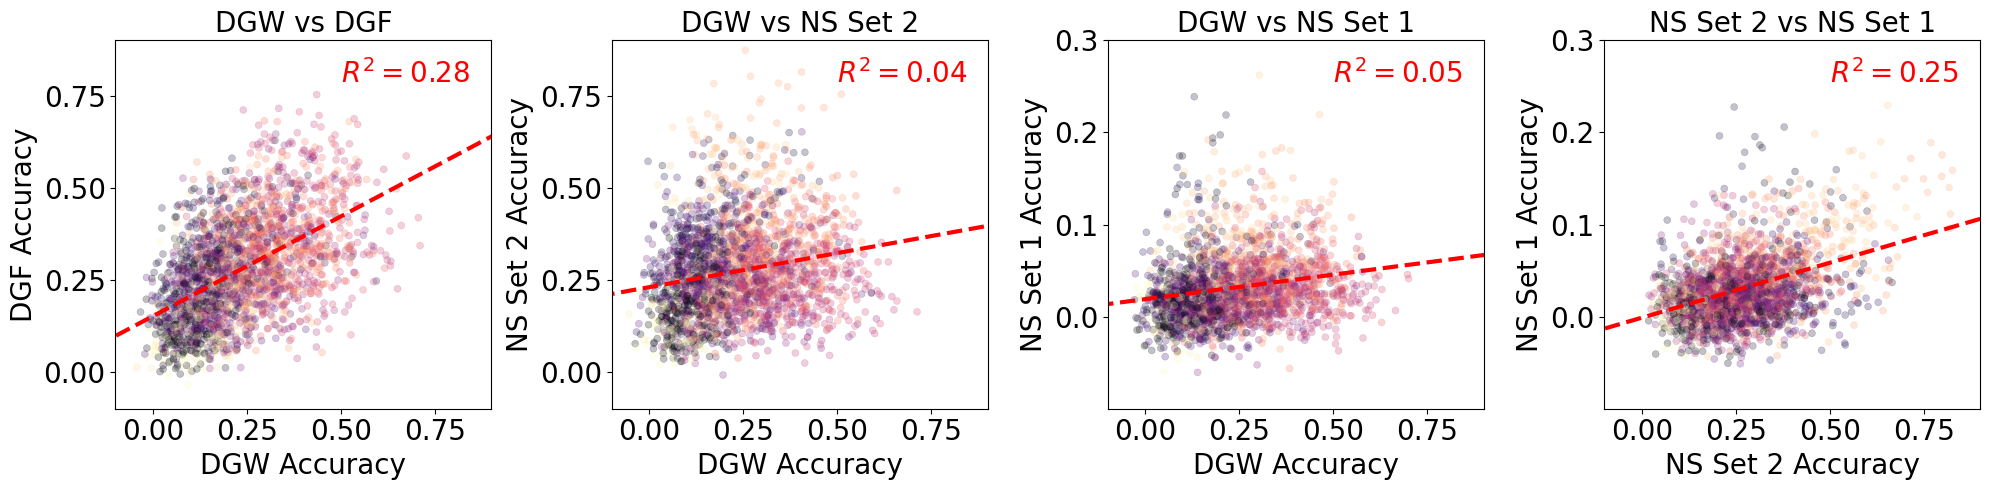

In [57]:
temp_df = all_results_df[all_results_df['depth'] <= 514]
temp_df =temp_df.sort_values(by=['mouse_id', 'column_id', 'volume_id', 'plane_id', 'stim_type_training'])
stim_pairs = [
    ("drifting_gratings_windowed", "drifting_gratings_full"),
    ("drifting_gratings_windowed", "natural_images_12"),
    ("drifting_gratings_windowed", "natural_images"),
    ("natural_images_12", "natural_images"),
]

stim_titles = {
    "drifting_gratings_windowed": "DGW",
    "drifting_gratings_full": "DGF",
    "natural_images": "NS Set 1",
    "natural_images_12": "NS Set 2"
}
from sklearn.linear_model import LinearRegression


fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for idx, pair in enumerate(stim_pairs):
    ax = axs[idx]
    stim_type_1, stim_type_2 = pair

    x_data = temp_df[temp_df['stim_type_training'] == stim_type_1].explode('val_accuracy').val_accuracy.values
    y_data = temp_df[temp_df['stim_type_training'] == stim_type_2].explode('val_accuracy').val_accuracy.values

    # x_data = x_data / chance[stim_type_1]
    # y_data = y_data / chance[stim_type_2]

    depth_values = temp_df[temp_df['stim_type_training'] == stim_type_1].explode('depth').depth.values
    depth_values = np.repeat(depth_values, 5)

    # add some jitter for better visibility
    jitter_amount = 0.02
    x_data += np.random.normal(0, jitter_amount, size=len(x_data))
    y_data += np.random.normal(0, jitter_amount, size=len(y_data))

    # Create a scatter plot with depth as the hue
    # axs.set_title('Decoding Performance: DGF vs DGW', fontsize=20)
    ax.set_title(f"{stim_titles[stim_type_1]} vs {stim_titles[stim_type_2]}", fontsize=20)
    # ax.plot([-1, 1], [-1, 1], color='black', linestyle='-', linewidth=1, zorder=0)
    sns.scatterplot(
        x=x_data, 
        y=y_data, 
        hue=depth_values, 
        palette='magma_r', 
        s=25, 
        alpha=0.25,
        edgecolor=None,
        ax=ax
    )
    x_data = temp_df[temp_df['stim_type_training'] == stim_type_1].explode('val_accuracy').val_accuracy.values
    y_data = temp_df[temp_df['stim_type_training'] == stim_type_2].explode('val_accuracy').val_accuracy.values
    ax.get_legend().remove()
    sm = plt.cm.ScalarMappable(cmap='magma_r', norm=plt.Normalize(vmin=depth_values.min(), vmax=depth_values.max()))
    sm.set_array([])
    # ax.figure.colorbar(sm, ax=ax) if idx == 3 else None

    ax.set_xlim(-0.1, 0.9) 
    ax.set_ylim(-0.1, 0.9) if idx < 2 else ax.set_ylim(-0.1, 0.3)
    ax.set_xticks([0, 0.25, 0.5, 0.75])
    ax.set_yticks([0, 0.25, 0.5, 0.75]) if idx < 2 else ax.set_yticks([0, 0.1, 0.2, 0.3])

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(x_data.reshape(-1, 1), y_data)
    
    # Plot the regression line
    x_fit = np.linspace(-1, 1, 100)
    y_fit = model.predict(x_fit.reshape(-1, 1))
    ax.plot(x_fit, y_fit, color='red', linestyle='--', linewidth=3, label='Linear Regression')

    # Add text annotation for R^2 value
    r_squared = model.score(x_data.reshape(-1, 1), y_data)
    ax.text(0.60, 0.95, f'$R^2 = {r_squared:.2f}$', 
            transform=ax.transAxes, fontsize=20, verticalalignment='top', color='red')
        
    # ax.set_yticks([]) if idx > 0 else None
    # ax.set_aspect('equal')
    ax.set_xlabel(f'{stim_titles[stim_type_1]} Accuracy', fontsize=20)
    ax.set_ylabel(f'{stim_titles[stim_type_2]} Accuracy', fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)
    # plt.tight_layout()
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG2E_regress_compare_decoding.png'), dpi=300)

### FIGURE 2A -- KNN DECODING SCHEMATIC

In [12]:
import sys, os
sys.path.insert(0, '/home/naomi/Desktop/code/v1dd-public/analysis-runner')
import run_decoding
from allen_v1dd.client import OPhysClient
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from v1dd_public import ARTIFACT_DIR

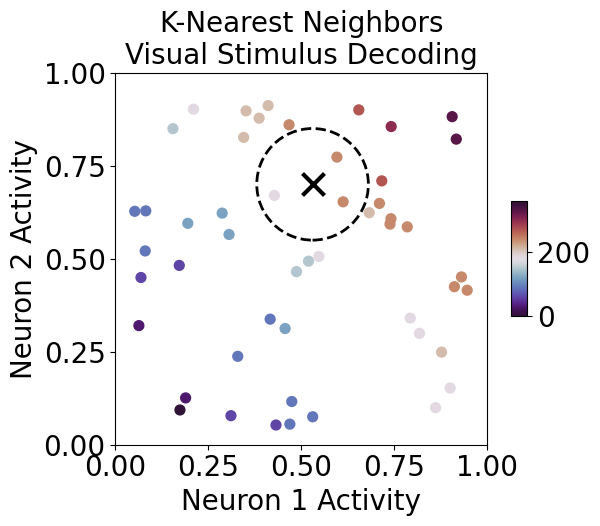

In [18]:
#### k-nearest neighbors decoding schematic for 2 simulated neurons
np.random.seed(12) # Set seed for reproducibility

# Create figure and figure parameters 
fig, ax = plt.subplots(figsize=(6, 6))
fontsize = 20

# Create some sample data
n = 50  # number of points
lower_bound = 0.05
upper_bound = 0.95
x_values = (np.random.rand(n) * (upper_bound - lower_bound) + lower_bound)
y_values = (np.random.rand(n) * (upper_bound - lower_bound) + lower_bound)

x_bins = np.linspace(lower_bound, upper_bound, 8)  # 12 bins for the 12 orientations
y_bins = np.linspace(lower_bound, upper_bound, 7)  # Same bins for y values
x_indices = np.digitize(x_values, x_bins) - 1  # Get bin indices for x values
y_indices = np.digitize(y_values, y_bins) - 1  # Get bin indices for y values

# Create orientations based on the bin indices
orientations = (x_indices + y_indices) % 12 * 30  # Example orientations based on x and y indices

ax.scatter(x_values, y_values, c=orientations, cmap='twilight_shifted', marker='o', s=50, alpha=1, vmin=0, vmax=360)
cbar = plt.colorbar(ax.collections[0], ax=ax, aspect=7, shrink=0.25, location='right')
cbar.ax.tick_params(labelsize=fontsize)

test_pt = (0.53, 0.7)
ax.scatter(test_pt[0], test_pt[1], c='black', marker='x', s=250, alpha=1, linewidth=3, label='Test Trial')
ax.add_patch(plt.Circle(test_pt, radius=0.15, color='black', fill=False, linewidth=2, linestyle='--'))

ax.set_xlabel('Neuron 1 Activity', fontsize=fontsize)
ax.set_ylabel('Neuron 2 Activity', fontsize=fontsize)
ax.set_title('K-Nearest Neighbors\nVisual Stimulus Decoding', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_aspect('equal', adjustable='box')
plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG2A_knn_schematic.svg'), dpi=300)

### FIGURE 2B -- KNN DECODING TRAIN / TEST SETS FOR EXAMPLE SESSION

In [19]:
import sys, os
sys.path.insert(0, '/home/naomi/Desktop/code/v1dd-public/analysis-runner')
import run_decoding
from allen_v1dd.client import OPhysClient
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from v1dd_public import ARTIFACT_DIR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns

In [20]:
#### Load in data and perform k-nearest neighbors decoding

# Set up the client and load the session
mouse_id = 'M427836'
col_vol_str = '23'
plane = 1
plane_name = f"Plane_{plane}"

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")

# Get the X and Y data for decoding -- x_data is the dff traces and y_data is the stimulus direction
x_data = run_decoding.get_X_data(session, plane, "drifting_gratings_windowed") # T x N
y_data = run_decoding.get_Y_data(session, plane, "drifting_gratings_windowed", decode_dim="direction")
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Perform k-nearest neighbors decoding
param_grid = {'n_neighbors': list(range(1, 30))}
knn = KNeighborsClassifier(metric='correlation')
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_k = grid_search.best_params_['n_neighbors']
print(f"Best k: {best_k}")

# Fit the best model
knn = KNeighborsClassifier(n_neighbors=best_k, metric='correlation')
knn.fit(x_train, y_train)

# Predict on training and test data
y_pred_train = knn.predict(x_train)
y_pred_test = knn.predict(x_test)

# Calculate accuracy
print(f"Training accuracy: {metrics.accuracy_score(y_train, y_pred_train)}")
print(f"Test accuracy: {metrics.accuracy_score(y_test, y_pred_test)}")

Best k: 6
Training accuracy: 0.7058823529411765
Test accuracy: 0.6666666666666666


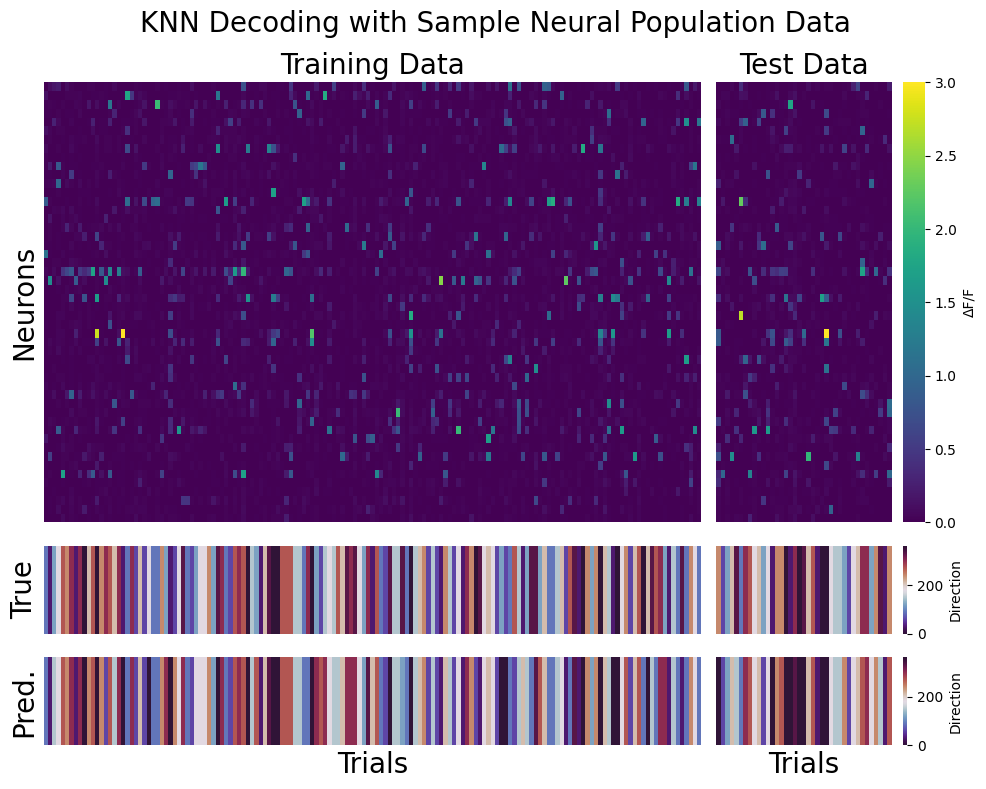

In [22]:
#### Plot the results

fig, axs = plt.subplots(3, 2, figsize=(10, 8), gridspec_kw={'height_ratios': [5, 1, 1], 'width_ratios': [3, 1]})
fontsize = 20
n1 = int(0.8 * len(y_data))

# plot subset of x_data (training data)
sns.heatmap(x_train.T[:50], 
            ax=axs[0][0], 
            cmap='viridis', 
            cbar_kws={'label': 'ΔF/F'}, 
            xticklabels=False, 
            yticklabels=False,
            vmin=0, vmax=3.0,
            cbar=False,
            rasterized=True,
            )
axs[0][0].set_title('Training Data', fontsize=fontsize)
axs[0][0].set_ylabel('Neurons', fontsize=fontsize)

# plot actual labels for training data
sns.heatmap(y_train.reshape(1, -1), 
            ax=axs[1][0], 
            cmap='twilight_shifted', 
            cbar_kws={'label': 'Direction'}, 
            xticklabels=False, 
            yticklabels=False,
            vmin=0, vmax=360,
            cbar=False,
            rasterized=True,
            )
axs[1][0].set_ylabel('True', fontsize=fontsize)

# plot predictions on training data
sns.heatmap(y_pred_train.reshape(1, -1),
            ax=axs[2][0], 
            cmap='twilight_shifted', 
            cbar_kws={'label': 'Direction'}, 
            xticklabels=False, 
            yticklabels=False,
            vmin=0, vmax=360,
            cbar=False,
            rasterized=True,
            )
axs[2][0].set_xlabel('Trials', fontsize=fontsize)
axs[2][0].set_ylabel('Pred.', fontsize=fontsize)


# plot subset of x_data (test data)
sns.heatmap(x_test.T[:50], 
            ax=axs[0][1], 
            cmap='viridis', 
            cbar_kws={'label': 'ΔF/F'}, 
            xticklabels=False, 
            yticklabels=False,
            vmin=0, vmax=3.0,
            rasterized=True,
            )
axs[0][1].set_title('Test Data', fontsize=fontsize)

# plot actual labels for test data
sns.heatmap(y_test.reshape(1, -1), 
            ax=axs[1][1], 
            cmap='twilight_shifted', 
            cbar_kws={'label': 'Direction'}, 
            xticklabels=False, 
            yticklabels=False,
            vmin=0, vmax=360,
            rasterized=True,
            )

# plot predictions on test data
sns.heatmap(y_pred_test.reshape(1, -1),
            ax=axs[2][1], 
            cmap='twilight_shifted', 
            cbar_kws={'label': 'Direction'}, 
            xticklabels=False, 
            yticklabels=False,
            vmin=0, vmax=360,
            rasterized=True,
            )
axs[2][1].set_xlabel('Trials', fontsize=fontsize)

fig.suptitle("KNN Decoding with Sample Neural Population Data", fontsize=fontsize)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG2B_dgw_decoding_example_{mouse_id}_{col_vol_str}_{plane_name}.svg'), dpi=300)

### FIGURE 2C -- HIGH PERFORMANCE DECODING AND LOW PERFORMANCE DECODING

In [23]:
import sys, os
sys.path.insert(0, '/home/naomi/Desktop/code/v1dd-public/analysis-runner')
import run_decoding
from allen_v1dd.client import OPhysClient
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from v1dd_public import ARTIFACT_DIR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns

In [24]:
#### Load in data and perform knn decoding (HIGH PERFORMANCE EXAMPLE)

# Set up the client and load the session
mouse_id = 'M427836'
col_vol_str = '23'
plane = 1
plane_name = f"Plane_{plane}"

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")

# Get the X and Y data for decoding -- x_data is the dff traces and y_data is the stimulus direction
x_data_HIGH = run_decoding.get_X_data(session, plane, "drifting_gratings_windowed") # T x N
y_data_HIGH = run_decoding.get_Y_data(session, plane, "drifting_gratings_windowed", decode_dim="direction")
x_train_HIGH, x_test_HIGH, y_train_HIGH, y_test_HIGH = train_test_split(x_data_HIGH, y_data_HIGH, test_size=0.2, random_state=42)

# Perform k-nearest neighbors decoding
param_grid = {'n_neighbors': list(range(1, 30))}
knn = KNeighborsClassifier(metric='correlation')
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_HIGH, y_train_HIGH)
best_k_HIGH = grid_search.best_params_['n_neighbors']

# Fit the best model
knn = KNeighborsClassifier(n_neighbors=best_k_HIGH, metric='correlation')
knn.fit(x_train_HIGH, y_train_HIGH)

# Predict on training and test data
y_pred_train_HIGH = knn.predict(x_train_HIGH)
y_pred_test_HIGH = knn.predict(x_test_HIGH)

# Calculate accuracy
print('HIGH PERFORMANCE EXAMPLE')
print(f"Training accuracy: {metrics.accuracy_score(y_train_HIGH, y_pred_train_HIGH)}")
print(f"Test accuracy: {metrics.accuracy_score(y_test_HIGH, y_pred_test_HIGH)}")

HIGH PERFORMANCE EXAMPLE
Training accuracy: 0.7058823529411765
Test accuracy: 0.6666666666666666


In [25]:
#### Load in data and perform knn decoding (HIGH PERFORMANCE EXAMPLE)

# Set up the client and load the session
mouse_id = 'M427836'
col_vol_str = '25'
plane = 6
plane_name = f"Plane_{plane}"

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")

# Get the X and Y data for decoding -- x_data is the dff traces and y_data is the stimulus direction
x_data_LOW = run_decoding.get_X_data(session, plane, "drifting_gratings_windowed") # T x N
y_data_LOW = run_decoding.get_Y_data(session, plane, "drifting_gratings_windowed", decode_dim="direction")
x_train_LOW, x_test_LOW, y_train_LOW, y_test_LOW = train_test_split(x_data_LOW, y_data_LOW, test_size=0.2, random_state=42)

# Perform k-nearest neighbors decoding
param_grid = {'n_neighbors': list(range(1, 30))}
knn = KNeighborsClassifier(metric='correlation')
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_LOW, y_train_LOW)
best_k_LOW = grid_search.best_params_['n_neighbors']

# Fit the best model
knn = KNeighborsClassifier(n_neighbors=best_k_LOW, metric='correlation')
knn.fit(x_train_LOW, y_train_LOW)

# Predict on training and test data
y_pred_train_LOW = knn.predict(x_train_LOW)
y_pred_test_LOW = knn.predict(x_test_LOW)

# Calculate accuracy
print('LOW PERFORMANCE EXAMPLE')
print(f"Training accuracy: {metrics.accuracy_score(y_train_LOW, y_pred_train_LOW)}")
print(f"Test accuracy: {metrics.accuracy_score(y_test_LOW, y_pred_test_LOW)}")

LOW PERFORMANCE EXAMPLE
Training accuracy: 0.2679738562091503
Test accuracy: 0.07692307692307693


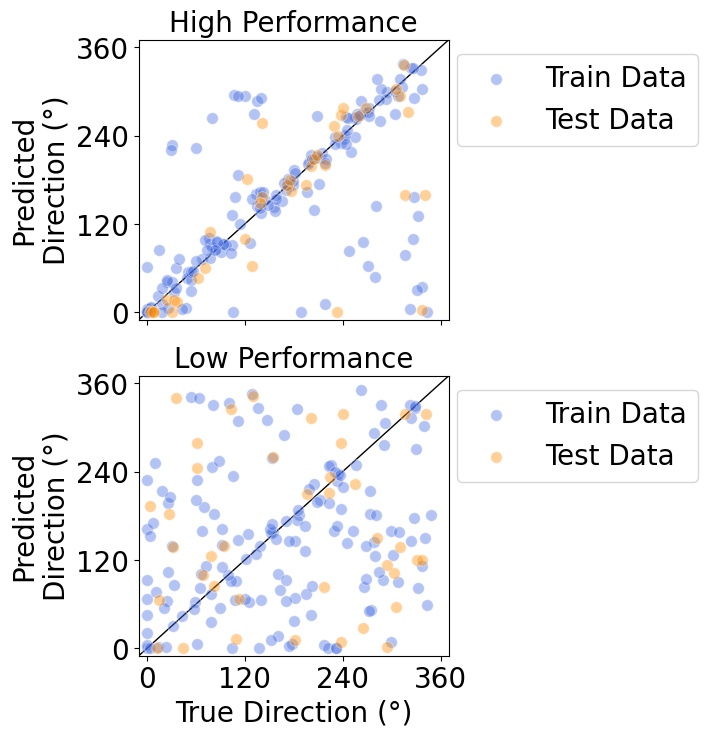

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(4, 8), sharex=True, sharey=True)
fontsize = 20
noise_std = 10

y_train_HIGH_copy = y_train_HIGH.copy()
y_pred_train_HIGH_copy = y_pred_train_HIGH.copy()
y_train_LOW_copy = y_train_LOW.copy()
y_pred_train_LOW_copy = y_pred_train_LOW.copy()

y_test_HIGH_copy = y_test_HIGH.copy()
y_pred_test_HIGH_copy = y_pred_test_HIGH.copy()
y_test_LOW_copy = y_test_LOW.copy()
y_pred_test_LOW_copy = y_pred_test_LOW.copy()

# Plot high performance example
ax = axs[0]

y_train_HIGH_copy += np.random.normal(0, noise_std, size=y_train_HIGH_copy.shape)  # Add some jitter for better visualization
y_pred_train_HIGH_copy += np.random.normal(0, noise_std, size=y_pred_train_HIGH_copy.shape)  # Add some jitter for better visualization
y_train_HIGH_copy = np.clip(y_train_HIGH_copy, 0, 360)  # Ensure values are within 0-360
y_pred_train_HIGH_copy = np.clip(y_pred_train_HIGH_copy, 0, 360)
sns.scatterplot(
    x=y_train_HIGH_copy,
    y=y_pred_train_HIGH_copy,
    alpha=0.4,
    s=70, 
    color='royalblue',
    ax=ax,
    zorder=1,
    legend=False,
)
y_test_HIGH_copy += np.random.normal(0, noise_std, size=y_test_HIGH_copy.shape)  # Add some jitter for better visualization
y_pred_test_HIGH_copy += np.random.normal(0, noise_std, size=y_pred_test_HIGH_copy.shape)  # Add some jitter for better visualization
y_test_HIGH_copy = np.clip(y_test_HIGH_copy, 0, 360)  # Ensure values are within 0-360
y_pred_test_HIGH_copy = np.clip(y_pred_test_HIGH_copy, 0, 360)
sns.scatterplot(
    x=y_test_HIGH_copy,
    y=y_pred_test_HIGH_copy,
    alpha=0.4,
    color='darkorange',
    s=70, 
    ax=ax,
    zorder=2,
    legend=False,
)
ax.plot([-40, 400], [-40, 400], color='black', linestyle='-', linewidth=1, zorder=0)  # Diagonal line for perfect prediction
ax.set_xticks((0, 100, 200, 300))
ax.set_yticks((0, 100, 200, 300))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend({'Train Data', 'Test Data'}, loc='upper right', bbox_to_anchor=(1.85, 1), fontsize=fontsize)
ax.set_ylabel('Predicted\nDirection (°)', fontsize=fontsize)
ax.set_title('High Performance', fontsize=fontsize)

# Plot low performance example
ax = axs[1]
y_train_LOW_copy += np.random.normal(0, noise_std, size=y_train_LOW_copy.shape)  # Add some jitter for better visualization
y_pred_train_LOW_copy += np.random.normal(0, noise_std, size=y_pred_train_LOW_copy.shape)  # Add some jitter for better visualization
y_train_LOW_copy = np.clip(y_train_LOW_copy, 0, 360)  # Ensure values are within 0-360
y_pred_train_LOW_copy = np.clip(y_pred_train_LOW_copy, 0, 360)
sns.scatterplot(
    x=y_train_LOW_copy,
    y=y_pred_train_LOW_copy,
    alpha=0.4,
    s=70, 
    color='royalblue',
    ax=ax,
    zorder=1,
    legend=False,
)
y_test_LOW_copy += np.random.normal(0, noise_std, size=y_test_LOW_copy.shape)  # Add some jitter for better visualization
y_pred_test_LOW_copy += np.random.normal(0, noise_std, size=y_pred_test_LOW_copy.shape)  # Add some jitter for better visualization
y_test_LOW_copy = np.clip(y_test_LOW_copy, 0, 360)  # Ensure values are within 0-360
y_pred_test_LOW_copy = np.clip(y_pred_test_LOW_copy, 0, 360)
sns.scatterplot(
    x=y_test_LOW_copy,
    y=y_pred_test_LOW_copy,
    alpha=0.4,
    color='darkorange',
    s=70, 
    ax=ax,
    zorder=2,
    legend=False,
)
ax.plot([-40, 400], [-40, 400], color='black', linestyle='-', linewidth=1, zorder=0)  # Diagonal line for perfect prediction
ax.set_xlim(-10, 370)
ax.set_ylim(-10, 370)
ax.set_xticks((0, 120, 240, 360))
ax.set_yticks((0, 120, 240, 360))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend({'Train Data', 'Test Data'}, loc='upper right', bbox_to_anchor=(1.85, 1), fontsize=fontsize)
ax.set_xlabel('True Direction (°)', fontsize=fontsize)
ax.set_ylabel('Predicted\nDirection (°)', fontsize=fontsize)
ax.set_title('Low Performance', fontsize=fontsize)

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG2C_high_low_decoding_performance.svg'), dpi=300)